# ライブラリ

In [3]:
# !pip install librosa
# !pip install tqdm

In [7]:
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch

print(librosa.__version__)
print(torch.__version__)


0.10.2.post1
2.2.2



# ファイル読み込み

In [9]:
# # 変数定義
sr = 44100 #サンプリング周波数

# #ファイルパスの指定
# train = "../raw_data/contacting_object/train_data/" #NASのデータ
# # audio_dir = "../Data_contacting_object/initial/FOLDER02" #ローカルデータ
# eval = "../raw_data/contacting_object/initial/FOLDER03/" 


# #学習用データの読み込み
# audio_dir = train
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+"_Tr1.WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)

# #評価用データの読み込み
# folderPath = eval
# subFolders = [f for f in os.listdir(folderPath) if os.path.isdir(os.path.join(folderPath, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatas_eに音声データを格納していく
# originDatas_e = []
# for subFolder in subFolders:
#     filePath = folderPath+"/"+subFolder+"/"+subFolder+"_Tr1.WAV"
#     originData_e, sr = librosa.load(filePath, sr = sr)
#     originDatas_e.append(originData_e)


# #1データから30試行をトリミングを22パターン分行い，soundDatasetに格納する
# # soundDatasetの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset = np.append(soundDataset,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset = soundDataset.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset.shape)

# import pickle
# f = open('soundDataset.pickle','wb')
# pickle.dump(soundDataset,f)

In [3]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset = pickle.load(f)

In [4]:
#正解ラベルリストの作成

#object層
objectLabel = [
    "Y-shirt", 
    "Jeans", 
    "Sweatshirt", 

    "Blanket", 
    "bedquilt", 
    "Pillow", 
    
    "Thick Book", 
    "Thin Book", 
    "Cardboard", 
    
    "Mousepad", 
    "Chair", 
    "Sofa", 
    
    "Metal Desk", 
    "Laptop", 
    "AlumiRack", 
    
    "WoodDesk", 
    "WoodShelf", 
    "Floor", 
    
    "Small Organizer", 
    "PlaBag", 
    "PlaShelf"
]

#material層
matLabel = [
    "Clothing",
    "Clothing", 
    "Paper", 
    "Memory Foam", 
    "Metal", 
    "Wood", 
    "Plastic"
]

matNum = [0,0,1,2,3,4,5]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





In [5]:
print(len(soundDataset))

21


### 評価データセット

In [10]:
IPython.display.Audio(data=soundDataset[1][0], rate=sr)

### スペクトログラムの描写

In [11]:
# # パターンごとにスペクロログラムの描写
# for patern in range(len(soundDataset)):
#     trimData = soundDataset[patern,0]
#     spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
#     librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max)\
#                              , y_axis='mel', x_axis='time')# スペクトログラムを表示
    # plt.colorbar(format='%+2.0f dB')# カラーバーを追加
    # plt.ylim(0,500)
    # plt.title('Mel Spectrogram_'+objectLabel[patern])# グラフのタイトルを設定
    # plt.show()# グラフを表示


# 特徴量抽出

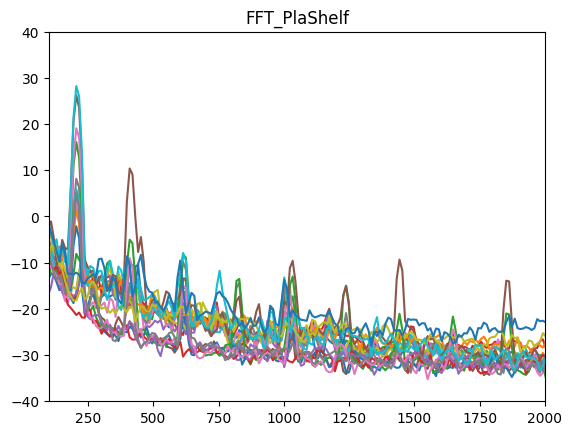

In [12]:

for i in range(soundDataset.shape[0]):
    title = 'FFT_'+objectLabel[i]
    #FFT
    data = soundDataset[i][0] # checked data
    win_wid = 4096
    win_ham = np.blackman(win_wid)

    #window幅で割り切れない分を削除する
    if data.shape[0] % win_wid != 0:
        data = data[0:-(data.shape[0] % win_wid)]



    #overlap & split window 
    overlap_rate = 0.5
    overlap = int(win_wid*overlap_rate)
    step = win_wid - overlap
    frames = []
    for start in range(0, len(data),step):
        end = start + win_wid  # 'end'を定義
        if end > len(data):
            break
        frame = data[start:end]
        frames.append(frame)

    #FFT
    fft_ret = np.fft.rfft(frames * win_ham) #FFT
    fft_freq = np.fft.rfftfreq(win_wid, 1/sr) #周波数軸のデータ作成

    #transfer amp to log
    log_fft_ret = 20*np.log10(np.abs(fft_ret)) # 対数データの取得←データを見やすくするため


    #plot result
    result_fft = np.mean(log_fft_ret, axis = 0)
    plt.title(title)
    plt.plot(fft_freq,result_fft)
    plt.xlim(100,2000)
    plt.ylim(-40,40)
    # plt.savefig('data/figure_obj/'+title+'.pdf')
    # plt.show()


In [13]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(soundDataset.shape[0]):
    for trial in range(soundDataset.shape[1]):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset[pattern][trial], sr=sr)
        
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])

        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)


(1050, 40)


In [14]:
# 形状を確認
print(mfccSet.shape)
print(mfccs.shape)

(1050, 40)
(20, 130)


# データセット作成

In [15]:
import pandas as pd
# num_feature次元のMFCCのデータフレームを作成
Dataset = pd.DataFrame(data=mfccSet)


Dataset['objectNum'] = [i // soundDataset.shape[1] for i in range(mfccSet.shape[0])]
Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset['shNum'] = np.repeat(shNum, 600)[:1050]

# データセットに'objectLabel'の列を追加
Dataset['object'] = np.repeat(objectLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset['sh'] = np.repeat(shLabel, 600)[:1050]




# Display the DataFrame
Dataset

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,objectNum,matNum,shNum,object,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,...,3.645248,3.399917,3.804335,3.734329,0,0,0,Y-shirt,Clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,...,3.640349,3.322606,3.285746,3.343535,0,0,0,Y-shirt,Clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,...,3.156580,3.407280,3.517655,3.547526,0,0,0,Y-shirt,Clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,...,3.725960,3.272637,3.092343,3.604951,0,0,0,Y-shirt,Clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,...,3.328177,3.571923,3.805326,4.301650,0,0,0,Y-shirt,Clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,...,3.297809,3.660277,3.493659,4.016997,20,5,1,PlaShelf,Plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,...,3.441372,3.365149,3.482850,4.577083,20,5,1,PlaShelf,Plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,...,3.539720,3.766647,4.083665,4.772348,20,5,1,PlaShelf,Plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,...,3.418645,3.032147,3.479765,4.267387,20,5,1,PlaShelf,Plastic,hard


In [16]:
! ls ../

NGC-DL-CONTAINER-LICENSE    dev    lib64   proc      srv  workspace
app			    etc    libx32  raw_data  sys
bin			    home   media   root      tmp
boot			    lib    mnt	   run	     usr
cuda-keyring_1.0-1_all.deb  lib32  opt	   sbin      var


In [17]:
# trial1 = Dataset.iloc[Dataset.index // 10 % 10 <= 4]
# trial2 = Dataset.iloc[Dataset.index // 10 % 10 > 4]

# ニューラルネット

In [282]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを取得
jst = pytz.timezone('Asia/Tokyo')

# 現在の日本時間を取得
now = datetime.now(jst)

# 時刻を指定された形式の文字列に変換
time = "_"+now.strftime("%Y%m%d%H%M")

print(time)

_202406070908


### 物体推定モデル

In [283]:

audio_origin = soundDataset.reshape(1050, -1)

t_df = Dataset.objectNum


audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor_sh = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor_sh)
dataset_origin

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train_origin, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

print(train_origin)


#学習データをnpへ変換
train_np = np.array([data.numpy() for data, _ in train_origin])
train_np_label = np.array([label for _, label in train_origin])

# #augmentation
train_aug_up = train_np*1.1
train_aug_down = train_np * 0.9
wn = np.random.randn(train_np.shape[0],66150)
train_aug_wn = train_np + wn
# print(train_np)
# print(train_aug_up)


train_np_aug = np.concatenate([train_aug_up,train_aug_down])
label_all = np.concatenate([train_np_label,train_np_label])
print(len(train_np_aug))
print(label_all)

train_np_aug = torch.tensor(train_np_aug,dtype=torch.float32)
label_all = torch.tensor(label_all, dtype=torch.int64)

train_aug = torch.utils.data.TensorDataset(train_np_aug, label_all)



train = train_origin

print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)



1050
525 262 263
1050
[ 9  1 14 ...  2 12  4]
525


In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class objNet(nn.Module):
    def __init__(self):
        super(objNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(40, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(40, 21, 8),
            nn.BatchNorm1d(21),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(21, 21, 8),
            nn.BatchNorm1d(21),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(42, 21),  # 入力サイズを修正
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(21, 21),  # 出力サイズを修正
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(21,1),
            # nn.Dropout(0.25)

        )

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = F.max_pool1d(h, kernel_size=160)
          
        h = self.conv3(h)
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.conv4(h) 
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.classifier(h)
        h = h.view(h.size(0), -1)  # Flatten
        return h

# モデルのインスタンス化
objnet = objNet()

# モデルの出力を計算してみる
input_data = torch.randn(10,1,66150)
print(input_data.shape)  
output = objnet(input_data)
print("Output shape:", output.shape)


torch.Size([10, 1, 66150])
Output shape: torch.Size([10, 21])


In [ ]:
# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
torch.cuda.current_device()

In [ ]:
# エポックの数
max_epoch = 50
     
# モデルの初期化
torch.manual_seed(0)



# モデルのインスタンス化とデバイスへの転送
net = objNet().to(device)

criterion = F.cross_entropy
criterion     

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net.train()
    for batch in train_loader:
        x, t = batch
        x = torch.unsqueeze(x, 1)
        # t = torch.unsqueeze(t, 0)
        x = x.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
            x = torch.unsqueeze(x, 1)
            # t = torch.unsqueeze(t, 0)
            x = x.to(device)
            t = t.to(device)
            
            y = net(x)
            loss = criterion(y, t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')




In [ ]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを取得
jst = pytz.timezone('Asia/Tokyo')

# 現在の日本時間を取得
now = datetime.now(jst)

# 時刻を指定された形式の文字列に変換
time = "_"+now.strftime("%Y%m%d%H%M")

# 学習曲線の可視化

title = 'Training and Validation Losses object'
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
# plt.savefig("data/"+title+time+".pdf")

plt.show()

In [ ]:
# # y_labelとtを同じデバイスに移動
# y_label = y_label.to(y.device)
# t = t.to(y.device)

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y, dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc

# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            
            y_label = torch.argmax(y, dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


### 材質推定モデル


In [ ]:
# モデルの初期化
torch.manual_seed(0)


audio_origin = soundDataset.reshape(1050, -1)
print(soundDataset.shape)
print(audio_origin.shape)

t_df = Dataset.matNum
audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor)
dataset_origin

dataset_augu = augumentation(audio_origin,66150,Dataset.matNum)

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

train = train 
print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
len(train_loader)

In [ ]:

audio_origin = soundDataset.reshape(1050, -1)

t_df = Dataset.matNum


audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor)
dataset_origin

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train_origin, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

print(train_origin)


#学習データをnpへ変換
train_np = np.array([data.numpy() for data, _ in train_origin])
train_np_label = np.array([label for _, label in train_origin])

# #augmentation
train_aug_up = train_np*1.2
train_aug_down = train_np * 0.8
wn = np.random.randn(train_np.shape[0],66150)
train_aug_wn = train_np + wn
print(train_aug_up.shape)


train_np_aug = np.concatenate([train_aug_up,train_aug_down,train_aug_wn])
label_all = np.concatenate([train_np_label,train_np_label,train_np_label])
print(len(train_np_aug))
print(label_all)

train_np_aug = torch.tensor(train_np_aug,dtype=torch.float32)
label_all = torch.tensor(label_all, dtype=torch.int64)

train_aug = torch.utils.data.TensorDataset(train_np_aug, label_all)



train = train_origin

print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class matNet(nn.Module):
    def __init__(self):
        super(matNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            # nn.Dropout(0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(40, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(40, 6, 8),
            nn.BatchNorm1d(6),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(6, 6, 8),
            nn.BatchNorm1d(6),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(42, 21),  # 入力サイズを修正
            nn.ReLU(),
            # nn.Dropout(0.25),
            
            nn.Linear(21, 10),  # 出力サイズを修正
            nn.ReLU(),
            # nn.Dropout(0.25),

            nn.Linear(10, 10),  # 出力サイズを修正
        )

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = F.max_pool1d(h, kernel_size=160)
          
        h = self.conv3(h)
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.conv4(h) 
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.classifier(h)
        h = h.view(h.size(0), -1)  # Flatten
        return h

# モデルのインスタンス化
matnet = matNet()

# モデルの出力を計算してみる
input_data = torch.randn(10,1,66150)
print(input_data.shape)  
output = matnet(input_data)
print("Output shape:", output.shape)

In [ ]:
# エポックの数
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

# モデルのインスタンス化とデバイスへの転送
net = matNet().to(device)

criterion = F.cross_entropy
criterion     

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net.train()
    for batch in train_loader:
        x, t = batch
        x = torch.unsqueeze(x, 1)
        # t = torch.unsqueeze(t, 0)
        x = x.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
            x = torch.unsqueeze(x, 1)
            # t = torch.unsqueeze(t, 0)
            x = x.to(device)
            t = t.to(device)
            
            y = net(x)
            loss = criterion(y, t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')




In [ ]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを取得
jst = pytz.timezone('Asia/Tokyo')

# 現在の日本時間を取得
now = datetime.now(jst)

# 時刻を指定された形式の文字列に変換
time = "_"+now.strftime("%Y%m%d%H%M")

# 学習曲線の可視化

title = 'Training and Validation Losses material'
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig("data/"+title+time+".pdf")

plt.show()

In [ ]:
# y_labelとtを同じデバイスに移動
y_label = y_label.to(y.device)
t = t.to(y.device)

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y, dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            
            y_label = torch.argmax(y, dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


In [ ]:
device = torch.cuda.is_available() 
print(device)

import torch
print(torch.__version__)
print(torch.version.cuda)


### 剛柔推定モデル

In [ ]:
# モデルの初期化
torch.manual_seed(0)


audio_origin = soundDataset.reshape(1050, -1)
print(soundDataset.shape)
print(audio_origin.shape)

t_df = Dataset.shNum
audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor_sh = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor_sh)
dataset_origin

# dataset_augu = augumentation(audio_origin,66150,Dataset.shNum)

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

train = train 
print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
len(train_loader)

In [ ]:

audio_origin = soundDataset.reshape(1050, -1) # type: ignore

t_df = Dataset.shNum


audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor)
dataset_origin

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train_origin, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

print(train_origin)


#学習データをnpへ変換
train_np = np.array([data.numpy() for data, _ in train_origin])
train_np_label = np.array([label for _, label in train_origin])

# #augmentation
train_aug_up = train_np*1.2
train_aug_down = train_np * 0.8
wn = np.random.randn(train_np.shape[0],66150)
train_aug_wn = train_np + wn
print(train_aug_up.shape)


train_np_aug = np.concatenate([train_aug_up,train_aug_down,train_aug_wn])
label_all = np.concatenate([train_np_label,train_np_label,train_np_label])
print(len(train_np_aug))
print(label_all)

train_np_aug = torch.tensor(train_np_aug,dtype=torch.float32)
label_all = torch.tensor(label_all, dtype=torch.int64)

train_aug = torch.utils.data.TensorDataset(train_np_aug, label_all)



train = train_origin 

print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class shNet(nn.Module):
    def __init__(self):
        super(shNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            # nn.Dropout(0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(40, 40, 8),
            nn.BatchNorm1d(40),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(40, 2, 8),
            nn.BatchNorm1d(2),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(2, 2, 8),
            nn.BatchNorm1d(2),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(42, 21),  # 入力サイズを修正
            nn.ReLU(),
            # nn.Dropout(0.25),
            
            nn.Linear(21, 2),  # 出力サイズを修正
            nn.ReLU(),
            # nn.Dropout(0.25),

            nn.Linear(2,2),  # 出力サイズを修正
        )

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = F.max_pool1d(h, kernel_size=160)
          
        h = self.conv3(h)
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.conv4(h) 
        h = F.max_pool1d(h, kernel_size=3) 
        h = self.classifier(h)
        h = h.view(h.size(0), -1)  # Flatten
        return h

# モデルのインスタンス化
shnet = shNet()

# モデルの出力を計算してみる
input_data = torch.randn(10,1,66150)
print(input_data.shape)  
output = shnet(input_data)
print("Output shape:", output.shape)

In [ ]:
# エポックの数
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# モデルのインスタンス化とデバイスへの転送
net = shNet().to(device)

criterion = F.cross_entropy
# criterion     

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net.train()
    for batch in train_loader:
        x, t = batch
        x = torch.unsqueeze(x, 1)
        # t = torch.unsqueeze(t, 0)
        x = x.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
            x = torch.unsqueeze(x, 1)
            # t = torch.unsqueeze(t, 0)
            x = x.to(device)
            t = t.to(device)
            
            y = net(x)
            loss = criterion(y, t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')




In [ ]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを取得
jst = pytz.timezone('Asia/Tokyo')

# 現在の日本時間を取得
now = datetime.now(jst)

# 時刻を指定された形式の文字列に変換
time = "_"+now.strftime("%Y%m%d%H%M")

# 学習曲線の可視化

title = 'Training and Validation Losses Soft-hard'
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
# plt.savefig("data/"+title+time+".pdf")

plt.show()

In [ ]:


# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y, dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            
            y_label = torch.argmax(y, dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


# 転移学習


In [ ]:
# モデルの初期化
torch.manual_seed(0)


audio_origin = soundDataset.reshape(1050, -1)
print(soundDataset.shape)
print(audio_origin.shape)

t_df = Dataset.matNum
audio_tensor_dataset = torch.tensor(audio_origin, dtype=torch.float32)
label_tensor = torch.tensor(t_df, dtype=torch.int64)

# x と t を組み合わせて TensorDataset を作成
dataset_origin = torch.utils.data.TensorDataset(audio_tensor_dataset, label_tensor)
dataset_origin

# データセットを指定する
dataset = dataset_origin
print(len(dataset))
# 各データセットのサンプル数を決定
# train : val: test = 60%　: 20% : 20%

n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

train = train 
print(len(train))

# バッチサイズ
batch_size = 50

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
len(train_loader)

In [ ]:
# 転移学習
import copy
import torch.nn as nn

# 前提としてshNetが定義されている必要があります
# print(net)

transNet = shNet()

# パラメータ固定
for param in transNet.parameters():
    param.requires_grad = False

print(transNet.classifier)

# 畳み込み層の出力を計算するための入力サイズ（例：入力の長さが42の場合）
input_length = 42
conv_kernel_size = 8
conv_output_size = input_length - conv_kernel_size + 1

transNet.classifier = nn.Sequential(
    nn.Conv1d(2, 6, conv_kernel_size),
    nn.BatchNorm1d(6),
    nn.ReLU(),

    nn.Flatten(),  # 畳み込み層の出力をフラット化する

    nn.Linear(6 * conv_output_size, 21),  # 入力サイズを修正
    nn.ReLU(),
    
    nn.Linear(21, 10),  # 出力サイズを修正
    nn.ReLU(),

    nn.Linear(10, 10),  # 出力サイズを修正
)

print(transNet)


In [ ]:
# エポックの数
max_epoch = 100
     
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# モデルのインスタンス化とデバイスへの転送
net = transNet

net = net.to(device)
# net = trans_net

criterion = F.cross_entropy
  

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net.train()
    for batch in train_loader:
        x, t = batch
        x = torch.unsqueeze(x, 1)
        # t = torch.unsqueeze(t, 0)
        x = x.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
            x = torch.unsqueeze(x, 1)
            # t = torch.unsqueeze(t, 0)
            x = x.to(device)
            t = t.to(device)
            
            y = net(x)
            loss = criterion(y, t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')




In [ ]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを取得
jst = pytz.timezone('Asia/Tokyo')

# 現在の日本時間を取得
now = datetime.now(jst)

# 時刻を指定された形式の文字列に変換
time = "_"+now.strftime("%Y%m%d%H%M")

# 学習曲線の可視化

title = 'Training and Validation Losses Soft-hard'
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
# plt.savefig("data/"+title+time+".pdf")

plt.show()

In [ ]:


# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y, dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            
            y_label = torch.argmax(y, dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


# EfficientATのファインチューニング

### torchデータセットの作成

In [20]:
# パターンごとにスペクロログラムの保存
df = []
trial_num = 50
for patern in range (len(soundDataset)):
    for trial in range(trial_num):
        trimData = soundDataset[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        df.append(spectrogram_db)

df = np.array(df)
print(df.shape)
print(type(df))

(1050, 128, 130)
<class 'numpy.ndarray'>


In [21]:
print(df.shape) #(1050,128,130)


(1050, 128, 130)


In [99]:
# ラベルの指定
t_df = Dataset.shNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-16.1880, -10.2756, -10.2136,  ...,  -9.4156, -14.5458, -21.3748],
          [-16.2891, -15.6456, -12.7290,  ..., -14.3924, -25.2283, -24.1254],
          [-17.3913, -15.9702, -20.0184,  ..., -20.0343, -24.3928, -26.5555],
          ...,
          [-48.4910, -45.6473, -44.6052,  ..., -42.5551, -43.2055, -45.9880],
          [-48.3502, -44.7486, -43.4806,  ..., -42.5986, -43.2013, -46.5223],
          [-47.4865, -44.2736, -44.7912,  ..., -44.1931, -44.0013, -45.5822]]],


        [[[ -9.1079,  -7.2102,  -5.1802,  ...,  -3.1219,  -1.4221,  -1.6282],
          [ -9.1465, -10.0313, -10.1490,  ..., -14.1699,  -9.0928,  -7.1825],
          [-13.8148, -13.5277, -15.6352,  ..., -26.3621, -20.8560, -18.8614],
          ...,
          [-45.3104, -40.8363, -42.2715,  ..., -42.5708, -41.7785, -42.7498],
          [-46.9087, -43.1651, -41.5075,  ..., -43.9106, -44.0809, -43.9444],
          [-45.5507, -43.2805, -42.7816,  ..., -43.1379, -43.30

### soft-hard 1

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:

# ラベルの指定
t_df = Dataset.shNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [24]:
# modelのインポート
from models.dymn.model import get_model as get_dymn
model = get_dymn(pretrained_name="dymn10_as")

#パラメータの更新を許可
for param in model.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
model.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=2, bias=True)  # 新しい層

)
print(model)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = model.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_trained = net1


cuda:0
Epoch [1/150], Train Loss: 0.6765, Validation Loss: 1.8418
Epoch [2/150], Train Loss: 0.6678, Validation Loss: 1.1562
Epoch [3/150], Train Loss: 0.6637, Validation Loss: 1.0149
Epoch [4/150], Train Loss: 0.6535, Validation Loss: 1.0807
Epoch [5/150], Train Loss: 0.6110, Validation Loss: 1.8472
Epoch [6/150], Train Loss: 0.3521, Validation Loss: 2.3821
Epoch [7/150], Train Loss: 0.1891, Validation Loss: 1.8072
Epoch [8/150], Train Loss: 0.1459, Validation Loss: 0.5117
Epoch [9/150], Train Loss: 0.0800, Validation Loss: 0.5584
Epoch [10/150], Train Loss: 0.0721, Validation Loss: 0.3421
Epoch [11/150], Train Loss: 0.0823, Validation Loss: 0.2542
Epoch [12/150], Train Loss: 0.0376, Validation Loss: 0.0954
Epoch [13/150], Train Loss: 0.0335, Validation Loss: 0.2482
Epoch [14/150], Train Loss: 0.0346, Validation Loss: 0.1764
Epoch [15/150], Train Loss: 0.0466, Validation Loss: 0.1255
Epoch [16/150], Train Loss: 0.1040, Validation Loss: 1.4723
Epoch [17/150], Train Loss: 0.0199, Valida

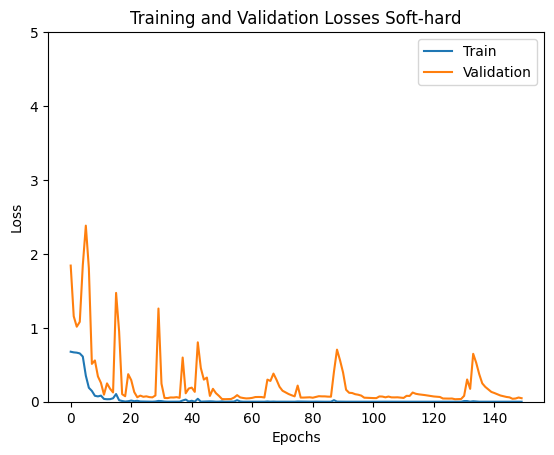

In [26]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [27]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 98.2%
Accuracy: 98.5%


tensor(0.9855)

In [28]:
# from models.dymn.model import get_model as get_dymn
# dymn10 = get_dymn(pretrained_name="dymn10_as")

# DataLoder(df,Dataset.matNum,25)
# FineTune(dymn10,5,1280,6)
# print(dymn10)
# TrainVall(dymn10,train_loader,val_loader,8)

# ShowTrainLoss(train_losses,val_losses,False)
# calc_acc(FineTune.net,val_loader)
# calc_acc(net,test_loader)

### material 1

In [29]:
# ラベルの指定
t_df = Dataset.matNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [30]:
from torchsummary import summary
# summary(net,(1,128,130))

In [31]:
matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=6, bias=True)  # 新しい層

)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


matModel_trained = net2


cuda:0
Epoch [1/150], Train Loss: 1.7325, Validation Loss: 1.6908
Epoch [2/150], Train Loss: 1.4973, Validation Loss: 1.3193
Epoch [3/150], Train Loss: 1.1405, Validation Loss: 1.2691
Epoch [4/150], Train Loss: 1.0787, Validation Loss: 1.0992
Epoch [5/150], Train Loss: 1.0313, Validation Loss: 1.0988
Epoch [6/150], Train Loss: 1.0314, Validation Loss: 1.0946
Epoch [7/150], Train Loss: 1.0013, Validation Loss: 1.0504
Epoch [8/150], Train Loss: 0.9693, Validation Loss: 1.0888
Epoch [9/150], Train Loss: 0.8751, Validation Loss: 1.1483
Epoch [10/150], Train Loss: 0.8533, Validation Loss: 1.0492
Epoch [11/150], Train Loss: 0.8248, Validation Loss: 1.1300
Epoch [12/150], Train Loss: 0.7323, Validation Loss: 1.1513
Epoch [13/150], Train Loss: 0.6837, Validation Loss: 1.6790
Epoch [14/150], Train Loss: 0.7350, Validation Loss: 1.3011
Epoch [15/150], Train Loss: 0.6743, Validation Loss: 1.3724
Epoch [16/150], Train Loss: 0.7063, Validation Loss: 1.0009
Epoch [17/150], Train Loss: 0.5774, Valida

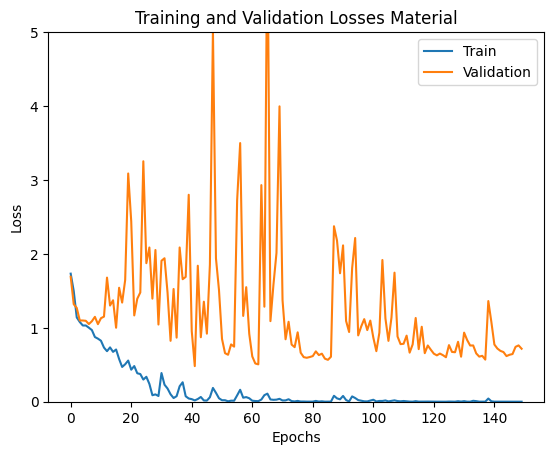

In [33]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [34]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 87.3%
Accuracy: 84.5%


tensor(0.8448)

### object 1

In [35]:
# ラベルの指定
t_df = Dataset.objectNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [36]:
objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=True)  # 新しい層

)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


objModel_trained = net3


cuda:0
Epoch [1/150], Train Loss: 3.0278, Validation Loss: 3.0198
Epoch [2/150], Train Loss: 2.9709, Validation Loss: 2.9448
Epoch [3/150], Train Loss: 2.7689, Validation Loss: 2.5568
Epoch [4/150], Train Loss: 2.2522, Validation Loss: 2.2272
Epoch [5/150], Train Loss: 1.8530, Validation Loss: 1.9331
Epoch [6/150], Train Loss: 1.6220, Validation Loss: 1.8476
Epoch [7/150], Train Loss: 1.5508, Validation Loss: 1.8055
Epoch [8/150], Train Loss: 1.4792, Validation Loss: 1.8295
Epoch [9/150], Train Loss: 1.4718, Validation Loss: 1.8003
Epoch [10/150], Train Loss: 1.3980, Validation Loss: 1.9794
Epoch [11/150], Train Loss: 1.4398, Validation Loss: 1.8589
Epoch [12/150], Train Loss: 1.3370, Validation Loss: 2.0071
Epoch [13/150], Train Loss: 1.2999, Validation Loss: 1.9319
Epoch [14/150], Train Loss: 1.2895, Validation Loss: 2.1634
Epoch [15/150], Train Loss: 1.2648, Validation Loss: 1.7984
Epoch [16/150], Train Loss: 1.3273, Validation Loss: 1.7300
Epoch [17/150], Train Loss: 1.2490, Valida

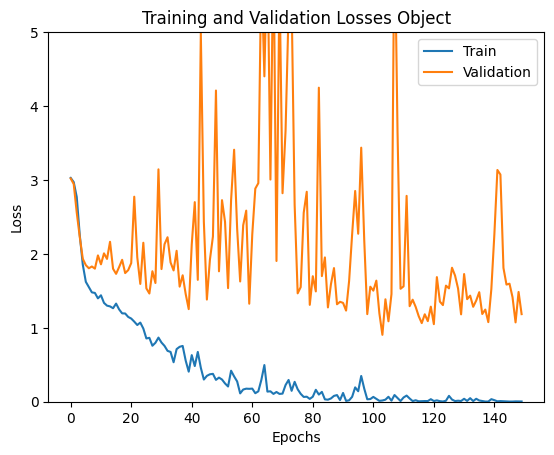

In [38]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Object'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [39]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 80.0%
Accuracy: 78.7%


tensor(0.7869)

### soft-hard 2

In [40]:
# ラベルの指定
t_df = Dataset.shNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [41]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=False),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層


)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 50
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_2_trained = net4


cuda:0
Epoch [1/50], Train Loss: 0.6698, Validation Loss: 0.6919
Epoch [2/50], Train Loss: 0.6400, Validation Loss: 0.6419
Epoch [3/50], Train Loss: 0.5180, Validation Loss: 0.3330
Epoch [4/50], Train Loss: 0.2368, Validation Loss: 0.1332
Epoch [5/50], Train Loss: 0.1027, Validation Loss: 0.0683
Epoch [6/50], Train Loss: 0.0433, Validation Loss: 0.0444
Epoch [7/50], Train Loss: 0.0243, Validation Loss: 0.0270
Epoch [8/50], Train Loss: 0.0128, Validation Loss: 0.0189
Epoch [9/50], Train Loss: 0.0070, Validation Loss: 0.0165
Epoch [10/50], Train Loss: 0.0053, Validation Loss: 0.0166
Epoch [11/50], Train Loss: 0.0037, Validation Loss: 0.0143
Epoch [12/50], Train Loss: 0.0024, Validation Loss: 0.0140
Epoch [13/50], Train Loss: 0.0024, Validation Loss: 0.0127
Epoch [14/50], Train Loss: 0.0025, Validation Loss: 0.0139
Epoch [15/50], Train Loss: 0.0017, Validation Loss: 0.0123
Epoch [16/50], Train Loss: 0.0058, Validation Loss: 0.0237
Epoch [17/50], Train Loss: 0.0023, Validation Loss: 0.0158

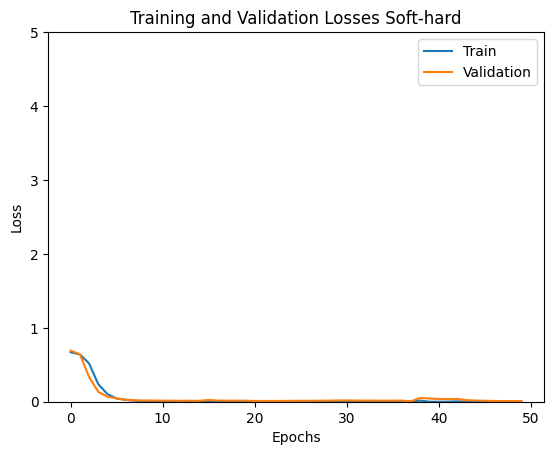

In [43]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [44]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 99.6%
Accuracy: 100.0%


tensor(1.)

### material 2

In [45]:
# ラベルの指定
t_df = Dataset.matNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [46]:
matModel_2 = shModel_2_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=False),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=6, bias=True),  # 新しい層
    # nn.ReLU(),
    # nn.Linear(in_features=2, out_features=21, bias=True),  # 新しい層
    # nn.ReLU(),
    # nn.Linear(in_features=21, out_features=6, bias=True),  # 新しい層
)
print(matModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
# for epoch in range(max_epoch):
train_epoch_loss = 1.0
val_epoch_loss = 1.0

while train_epoch_loss > 0.1 or val_epoch_loss  > 0.1 or epoch<50:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_2_trained = net5


cuda:0
Epoch [1/50], Train Loss: 1.7872, Validation Loss: 1.7734
Epoch [2/50], Train Loss: 1.7394, Validation Loss: 1.7454
Epoch [3/50], Train Loss: 1.6910, Validation Loss: 1.6852
Epoch [4/50], Train Loss: 1.5312, Validation Loss: 1.3821
Epoch [5/50], Train Loss: 1.1437, Validation Loss: 1.0934
Epoch [6/50], Train Loss: 0.8466, Validation Loss: 0.8820
Epoch [7/50], Train Loss: 0.5011, Validation Loss: 0.6129
Epoch [8/50], Train Loss: 0.1617, Validation Loss: 0.6176
Epoch [9/50], Train Loss: 0.0772, Validation Loss: 0.7202
Epoch [10/50], Train Loss: 0.0611, Validation Loss: 0.7038
Epoch [11/50], Train Loss: 0.0608, Validation Loss: 0.5331
Epoch [12/50], Train Loss: 0.0348, Validation Loss: 0.6136
Epoch [13/50], Train Loss: 0.0441, Validation Loss: 0.5472
Epoch [14/50], Train Loss: 0.0426, Validation Loss: 1.6313
Epoch [15/50], Train Loss: 0.1651, Validation Loss: 0.5805
Epoch [16/50], Train Loss: 0.0605, Validation Loss: 1.3454
Epoch [17/50], Train Loss: 0.0424, Validation Loss: 0.5780

KeyboardInterrupt: 

In [57]:
matModel_2_trained = net5


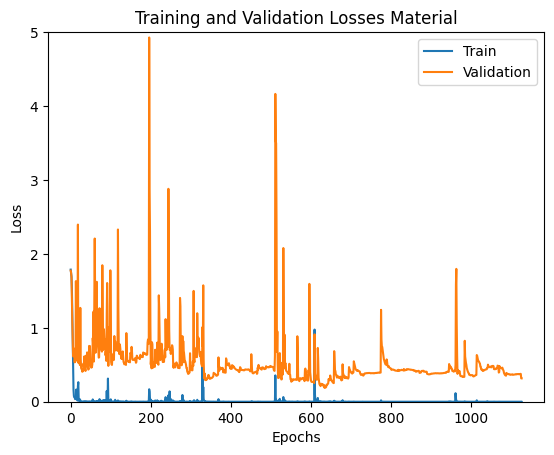

In [48]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [49]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 89.4%
Accuracy: 87.7%


tensor(0.8766)

### object 2

In [55]:
# ラベルの指定
t_df = Dataset.objectNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [58]:
objModel_2 = matModel_2_trained

#パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.Linear(in_features=527, out_features=176, bias=False), 
    nn.Linear(in_features=176, out_features=21, bias=False), 
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=False), 
    nn.ReLU(),
    nn.Linear(in_features=2, out_features=21, bias=False),  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=6, bias=False),  
    nn.ReLU(),
    nn.Linear(in_features=6, out_features=21, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=21, bias=True),  # 新しい層
)
print(objModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.2 )or epoch<100:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

objModel_2_trained = net6


cuda:0
Epoch [1/50], Train Loss: 3.0487, Validation Loss: 3.0682
Epoch [2/50], Train Loss: 3.0455, Validation Loss: 3.0697
Epoch [3/50], Train Loss: 3.0434, Validation Loss: 3.0714
Epoch [4/50], Train Loss: 3.0415, Validation Loss: 3.0731
Epoch [5/50], Train Loss: 3.0404, Validation Loss: 3.0747
Epoch [6/50], Train Loss: 3.0393, Validation Loss: 3.0763
Epoch [7/50], Train Loss: 3.0390, Validation Loss: 3.0777
Epoch [8/50], Train Loss: 3.0381, Validation Loss: 3.0792
Epoch [9/50], Train Loss: 3.0378, Validation Loss: 3.0804
Epoch [10/50], Train Loss: 3.0380, Validation Loss: 3.0818
Epoch [11/50], Train Loss: 3.0378, Validation Loss: 3.0828
Epoch [12/50], Train Loss: 3.0373, Validation Loss: 3.0836
Epoch [13/50], Train Loss: 3.0372, Validation Loss: 3.0843
Epoch [14/50], Train Loss: 3.0369, Validation Loss: 3.0849
Epoch [15/50], Train Loss: 3.0370, Validation Loss: 3.0855
Epoch [16/50], Train Loss: 3.0372, Validation Loss: 3.0860
Epoch [17/50], Train Loss: 3.0368, Validation Loss: 3.0863

KeyboardInterrupt: 

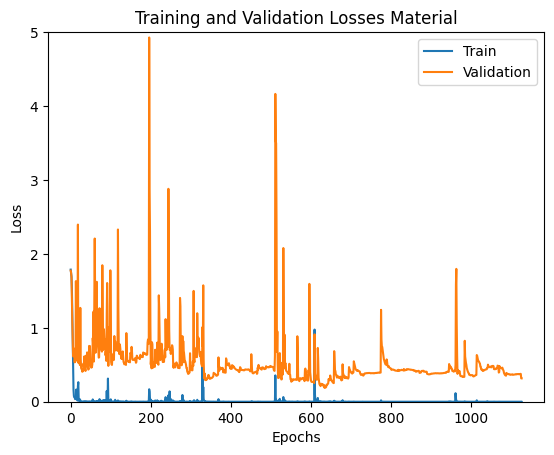

In [53]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [54]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

NameError: name 'net6' is not defined